# DNN-SE for IEEE 118-bus system

* Code is written by Shiva on March, 9, 2023

### The objective of this code is to get the generated V & I by the power flow solver in MATLAB and then use them as the inputs to a DNN-based SE by grabbing information associated with PMU locations and add noise to them
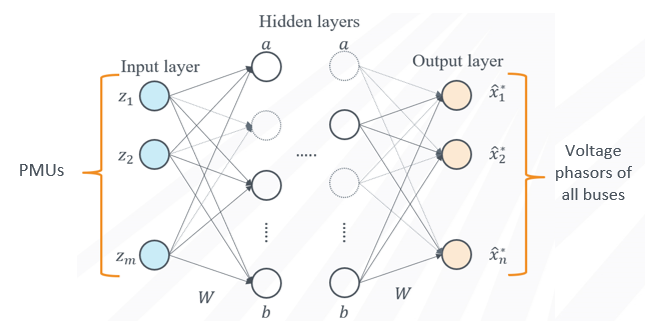

* Input layer includes voltage and current phasor measurement coming from PMU devices
* Num. of PMUs = 11 (at the highest voltage buses)
* Num. of measured features by PMUs = 82
* Num. of states to be estimated = 118x2 = 236
* Num. of training samples = 28k
* Num. of test samples = 4k

* x_train dimesnsion : (28k x 82)
* x_test dimesnsion : (4k x 82)

* y_train dimesnsion : (28k x 236)
* y_test dimesnsion : (4k x 236)

* After incremental PMU placemment in order to meet DOE requirements, the number of PMUs was set to 12.
* Num. of measured features by 12 PMUs = 90

### 1. Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

import math
from scipy import stats
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import gradients
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
from tensorflow.keras import losses
import h5py
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from time import time 
np.random.seed(123)
tf.random.set_seed(123)

### 2. Import system configuration

In [2]:
#Import the branch information of the 118-bus system (the connectivity between buses)
branch_inf= pd.read_csv('branch_index_118bus.csv',header=None)
branch_inf= np.array(branch_inf)
print(f'There are {branch_inf.shape[0]} branches in IEEE 118-bus system')

There are 186 branches in IEEE 118-bus system


### 3. Define PMU locations and find indexes associated with these locations

In [3]:
# 11 PMUs at highest-voltage buses
# pmu_list = [8,9,10,26,30,38,63,64,65,68,81] #List of bus numbers equipped with PMUs at highest voltage buses

#Incremental PMU Placement
inital_pmu_list = [8,9,10,26,30,38,63,64,65,68,81] #List of bus numbers equipped with PMUs at highest voltage buses
additional_pmu = [90]
pmu_list = sorted(inital_pmu_list + additional_pmu)

# below, we're trying to find indexes associated with current values measured by PMUs as we're going to grab only information reported by PMU devices not the whole data.
# Note that we have both from-end and to-end current measurements and we should discriminate them.
for i in pmu_list:
    It=[] # to-end
    If=[] # from-end
    
    for j in range(branch_inf.shape[0]):
        
        if i == branch_inf[j,0]:
            If.append(j) 
        
        if i == branch_inf[j,1]:
            It.append(j)
    
    # Store mesurement indexes measured by each PMU separately (If_for_pmu8 includes mesurement indexes associated with from-end current measurements measured by PMU placed at bus 8)
    temp1 = "If_for_pmu"+str(i)
    temp2 = "It_for_pmu"+str(i)
    globals()[temp1] = If
    globals()[temp2] = It

In [5]:
pmu_list

[8, 9, 10, 26, 30, 38, 63, 64, 65, 68, 81, 90]

### 4. Define a function for noise modeling

In [ ]:
# Build a 2-component non-Gaussian error model with the following configuration:
#Magnitude: Mu=[-0.004, 0.006] , Sigma=[0.0025 0.0025] , Weight = [0.4, 0.6]
#Angle : Mu = [-0.2, 0.3] , Sigma= [0.12, 0.12] , Weight = [0.4, 0.6]

def Varying_GMM_Error_vector_Creation(sample_size, Mu_vector, Sigma_vector, weight_vector): ## The GMM error 
    error = sample_size
    nsamp = sample_size
    data1 = stats.norm.rvs(loc=Mu_vector[0], scale=Sigma_vector[0], size=round(weight_vector[0]*sample_size)) 
    data1 = data1.reshape(-1, 1)
    data2 = stats.norm.rvs(loc=Mu_vector[1], scale=Sigma_vector[1], size=round(weight_vector[1]*sample_size)) 
    data2 = data2.reshape(-1, 1)
    GMM_vector = np.vstack((data1, data2)) 
    error = GMM_vector
    np.random.shuffle(error)
    return(error)

def NoisyAng(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.2, 0.3], [0.12, 0.12], [0.4, 0.6])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
        
    return x

def NoisyMag(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.004, 0.006], [0.0025, 0.0025], [0.4, 0.6])
#         y = 1+y #For Multiplicative error
#         x[:,i] = np.multiply(y, x[:,i].reshape(-1,1)).reshape(-1,) #Multiplicative error
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
## Multiplicative error is not suitable for values less than 1. But additive error is always workable.        
        
    return x

### In case you want to apply a Gaussian noise model instead of a non-Gaussian one

In [6]:
# Build a Gaussian error model
#Magnitude: Mu=[0] , Sigma=[0.01/3]
#Angle : Mu = [0] , Sigma= [0.573/3]

def Gaussian_error(sample_size, Mu, Sigma):
    error = sample_size
    nsamp = sample_size
    data1 = stats.norm.rvs(loc=Mu, scale=Sigma, size=sample_size)
    data1 = data1.reshape(-1, 1)
    error = data1
    np.random.shuffle(error)
    return(error)

def NoisyAng(x):
    for i in range (x.shape[1]):
        y = Gaussian_error(x.shape[0], [0], [0.573/3])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error      
    return x

def NoisyMag(x):
    for i in range (x.shape[1]):
        y = Gaussian_error(x.shape[0], [0], [0.01/3])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
## Multiplicative error is not suitable for values less than 1. But additive error is always workable.        
        
    return x

### 5. Import V & I data (previously generated in MATLAB by a power flow solver)

In [7]:
filepath1 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Train\Currents/' #File path to the training data-currents
filepath2 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Train\Voltages/' #File path to the training data-voltages

filepath3 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Test\Currents/' #File path to the test data-currents
filepath4 = r'D:\Shiva\Data Generation for IEEE 118-bus system\NEW - Updated P&Q Sampling\Test\Voltages/' #File path to the test data-voltages


# Training data
df_If_mag = pd.read_csv(filepath1+('If_mag_train_T1_12am.csv'), header = None)
df_If_ang = pd.read_csv(filepath1+('If_ang_train_T1_12am.csv'), header = None)
df_It_mag= pd.read_csv(filepath1+('It_mag_train_T1_12am.csv'), header = None)
df_It_ang = pd.read_csv(filepath1+('It_ang_train_T1_12am.csv'), header = None)
df_V_mag = pd.read_csv(filepath2+('VDATA_mag_train_T1_12am.csv'), header = None)
df_V_ang = pd.read_csv(filepath2+('VDATA_ang_train_T1_12am.csv'), header = None)

# Test data
df_If_mag_test = pd.read_csv(filepath3+('If_mag_test_T1_12am.csv'), header = None)
df_If_ang_test = pd.read_csv(filepath3+('If_ang_test_T1_12am.csv'), header = None)
df_It_mag_test= pd.read_csv(filepath3+('It_mag_test_T1_12am.csv'), header = None)
df_It_ang_test = pd.read_csv(filepath3+('It_ang_test_T1_12am.csv'), header = None)
df_V_mag_test = pd.read_csv(filepath4+('VDATA_mag_test_T1_12am.csv'), header = None)
df_V_ang_test = pd.read_csv(filepath4+('VDATA_ang_test_T1_12am.csv'), header = None)

### 6. Add noise to the imported data using that defined function

In [8]:
# Add noise to training data
If_mag_noisy = NoisyMag(np.array(df_If_mag))
If_ang_noisy = NoisyAng(np.array(df_If_ang))

It_mag_noisy = NoisyMag(np.array(df_It_mag))
It_ang_noisy = NoisyAng(np.array(df_It_ang))

V_mag_noisy = NoisyMag(np.array(df_V_mag))
V_ang_noisy = NoisyAng(np.array(df_V_ang))

In [9]:
# Add noise to test data
If_mag_noisy_test = NoisyMag(np.array(df_If_mag_test))
If_ang_noisy_test = NoisyAng(np.array(df_If_ang_test))

It_mag_noisy_test = NoisyMag(np.array(df_It_mag_test))
It_ang_noisy_test = NoisyAng(np.array(df_It_ang_test))

V_mag_noisy_test = NoisyMag(np.array(df_V_mag_test))
V_ang_noisy_test = NoisyAng(np.array(df_V_ang_test))

### 7. Create output data

In [11]:
# Output layer consists of actual voltage Mag & Ang for all the buses, so we need to concatenate them
y1_train = df_V_mag.to_numpy() #Mag
y2_train = df_V_ang.to_numpy() #Ang

y_train = np.concatenate((y1_train,y2_train) ,axis=1)
y_train.shape

(28000, 236)

In [12]:
# Create output layer for test data
y1_test = df_V_mag_test.to_numpy()
y2_test = df_V_ang_test.to_numpy()

y_test = np.concatenate((y1_test,y2_test) ,axis=1)
y_test.shape

(4000, 236)

### 8. Create input data
*  Use the identified indexes in Section 3 to grab information associated with PMUs for V & I

#### Training

In [13]:
counter = 0
for i in pmu_list:
    
    ###### Grab current Measurements ############
    
    ################## If ####################### 
    temp1= globals()["If_for_pmu"+str(i)]
    if bool(temp1):
        for j in temp1:
            globals()["d"+str(counter)] = If_mag_noisy[:,j]
            counter += 1
            globals()["d"+str(counter)] = If_ang_noisy[:,j]
            counter += 1
    pass

    ################## It #######################   
    temp2 = globals()["It_for_pmu"+str(i)]  
    if bool(temp2):
        for k in temp2:
            globals()["d"+str(counter)] = It_mag_noisy[:,k]
            counter += 1
            globals()["d"+str(counter)] = It_ang_noisy[:,k]
            counter += 1

            pass
        
    ###### Grab voltage Measurements ############
    globals()["d"+str(counter)] = V_ang_noisy[:,i-1]
    counter += 1
    globals()["d"+str(counter)] = V_mag_noisy[:,i-1]
    counter += 1

    
# Stack all data in a single matrix to define input data
whole_data = []
for m in range(0,counter):
    temp = globals()['d'+str(m)]
    whole_data.append(temp)

result = np.stack(whole_data, axis=0)

x_train = result.T

In [14]:
x_train.shape #82 features coming from PMUs

(28000, 90)

#### Test

In [15]:
counter = 0

for i in pmu_list:
    ###### Grab current Measurements ############
    ################## If ####################### 
    temp1= globals()["If_for_pmu"+str(i)]
    if bool(temp1):
        for j in temp1:
            globals()["d"+str(counter)] = If_mag_noisy_test[:,j]
            counter += 1
            globals()["d"+str(counter)] = If_ang_noisy_test[:,j]
            counter += 1
    pass

    ################## It #######################   
    temp2 = globals()["It_for_pmu"+str(i)]  
    if bool(temp2):
        for k in temp2:
            globals()["d"+str(counter)] = It_mag_noisy_test[:,k]
            counter += 1
            globals()["d"+str(counter)] = It_ang_noisy_test[:,k]
            counter += 1

            pass
    ###### Grab voltage Measurements ############
    globals()["d"+str(counter)] = V_ang_noisy_test[:,i-1]
    counter += 1
    globals()["d"+str(counter)] = V_mag_noisy_test[:,i-1]
    counter += 1

    

whole_data_test = []
for m in range(0,counter):
    temp = globals()['d'+str(m)]
    whole_data_test.append(temp)

result_test = np.stack(whole_data_test, axis=0)

x_test = result_test.T

In [16]:
x_test.shape

(4000, 90)

### 9. Normalization Process 

### 9.1. Min-Max Scaler

In [17]:
# We use min-max scaler to normalize data which scalesdat within 0~1

def normalize(x):
    
    x_min = np.amin(x)
    x_max = np.amax(x)
    x_norm = (x-x_min)/(x_max-x_min)
    
    return x_norm,x_min,x_max

In [18]:
#Normalizing Data based on the defined function
x_normalized_train = np.zeros(x_train.shape) 
y_normalized_train = np.zeros(y_train.shape)  
x_normalized_test = np.zeros(x_test.shape)
y_normalized_test = np.zeros(y_test.shape)  


for i in range(x_train.shape[1]):
    t1,x_min,x_max = normalize(x_train[:,i])
    x_normalized_train[:,i] = t1
    x_normalized_test[:,i] = (x_test[:,i]-x_min)/(x_max-x_min) #normalize test based on train
    

for j in range(y_train.shape[1]):
    t2,y_min,y_max = normalize(y_train[:,j])
    y_normalized_train[:,j] = t2
    y_normalized_test[:,j] = (y_test[:,j]-y_min)/(y_max-y_min)


# x_normalized_test = (x_test-x_min)/(x_max-x_min)
# y_normalized_test = (y_test-y_min)/(y_max-y_min)

C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_78600\3989276298.py:7: RuntimeWarning: invalid value encountered in divide
  x_norm = (x-x_min)/(x_max-x_min)
C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_78600\884511919.py:17: RuntimeWarning: invalid value encountered in divide
  y_normalized_test[:,j] = (y_test[:,j]-y_min)/(y_max-y_min)


### 9.2. Standrad Scaler
* If you have chosen Min-Max Scaler, skip this part

In [19]:
# x_mu = x_train.mean(axis=0)
# x_std = x_train.std(axis=0)

# x_normalized_train = (x_train - x_mu)/x_std
# x_normalized_test= (x_test - x_mu)/x_std

# y_mu = y_train.mean(axis=0)
# y_std = y_train.std(axis=0)

# y_normalized_train = (y_train - y_mu)/y_std
# y_normalized_test= (y_test - y_mu)/y_std

### 9.3. Save the original data

In [20]:
# Save the original data to be able to convert them back to actual values after training and evaluation
main_y_train = y_train
main_x_train = x_train
main_y_test = y_test
main_x_test = x_test

### 10. Data cleaning (check NaNs)

In [23]:
max_x_train = np.amax(x_normalized_train)
min_x_train = np.amin(x_normalized_train)
max_x_test = np.amax(x_normalized_test)
min_x_test = np.amin(x_normalized_test)

max_y_train = np.amax(y_normalized_train)
min_y_train = np.amin(y_normalized_train)
max_y_test = np.amax(y_normalized_test)
min_y_test = np.amin(y_normalized_test)

print('max_x_train = ',max_x_train,'\n',
      'min_x_train = ',min_x_train,'\n',
      'max_x_test= ',max_x_test,'\n',
      'min_x_test',min_x_test,'\n',
      'max_y_train = ',max_y_train,'\n',
      'min_y_train = ',min_y_train,'\n',

      'max_y_test= ',max_y_test,'\n',
      'min_y_test',min_y_test,'\n',
     )

max_x_train =  1.0 
 min_x_train =  0.0 
 max_x_test=  1.055229032376833 
 min_x_test -0.08471721128348765 
 max_y_train =  1.0 
 min_y_train =  0.0 
 max_y_test=  1.0666666666666584 
 min_y_test -0.12000000000000259 



###### Run the below cell in case there is any NaN or inf  in normalized data

In [22]:
y_normalized_train[np.isnan(y_normalized_train)] = 0
y_normalized_test[np.isnan(y_normalized_test)] = 0
x_normalized_train[np.isnan(x_normalized_train)] = 0
x_normalized_test[np.isnan(x_normalized_test)] = 0

### 11. Split data in train and validation

In [24]:
# split train and validation 
x_train, x_val, y_train, y_val = train_test_split(x_normalized_train, y_normalized_train, test_size=0.2)

x_test = x_normalized_test
y_test = y_normalized_test

### 12. Let's train the model (DNN-SE)

In [ ]:
dp = 0.3 # set Dropout rate 
nu = 600 # number of neurons in each layer 
ne = 4000 # number of epochs

#################################### Model Architecture #############################################
model = Sequential()

model.add(Dense(nu, activation='relu', input_dim=x_train.shape[1], kernel_initializer='he_normal')) # Hidden 1
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 2
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 3
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 4
model.add(BatchNormalization())
model.add(Dropout(dp))

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 5
# model.add(BatchNormalization())
# model.add(Dropout(dp))

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 6

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 7



model.add(Dense(y_train.shape[1], activation='linear',kernel_initializer='he_normal')) # Output

################################## Model Configuration #####################################

# Adam(learning_rate=0.09456, beta_1=0.9, beta_2=0.999, amsgrad=False) # set configuration of Optimizer
# model.compile(loss='mean_absolute_error', metrics = ['mae'], optimizer='adam')
# reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.2,patience=10, min_lr=0.0001)
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True)


loss_fn = losses.MeanSquaredError() # set loss function 
Adam(learning_rate=0.09456, beta_1=0.9, beta_2=0.999, amsgrad=False) # set configuration of Optimizer
model.compile(loss=loss_fn, optimizer='adam', metrics=['MSE'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.0001)
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,save_weights_only=True, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(x_train,y_train,verbose=1,epochs=ne , validation_data = (x_val,y_val),batch_size=100,callbacks=[checkpoint,reduce_lr])

# plot training history
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


Epoch 1/4000
222/224 [============================>.] - ETA: 0s - loss: 0.7312 - MSE: 0.7312
Epoch 1: val_loss improved from inf to 0.01787, saving model to weights.best.hdf5
224/224 [==============================] - 9s 31ms/step - loss: 0.7266 - MSE: 0.7266 - val_loss: 0.0179 - val_MSE: 0.0179 - lr: 0.0010
Epoch 2/4000
224/224 [==============================] - ETA: 0s - loss: 0.1266 - MSE: 0.1266
Epoch 2: val_loss improved from 0.01787 to 0.01150, saving model to weights.best.hdf5
224/224 [==============================] - 8s 37ms/step - loss: 0.1266 - MSE: 0.1266 - val_loss: 0.0115 - val_MSE: 0.0115 - lr: 0.0010
Epoch 3/4000
222/224 [============================>.] - ETA: 0s - loss: 0.0417 - MSE: 0.0417
Epoch 3: val_loss improved from 0.01150 to 0.01025, saving model to weights.best.hdf5
224/224 [==============================] - 7s 32ms/step - loss: 0.0416 - MSE: 0.0416 - val_loss: 0.0102 - val_MSE: 0.0102 - lr: 0.0010
Epoch 4/4000
222/224 [============================>.] - ETA: 0

224/224 [==============================] - ETA: 0s - loss: 0.0070 - MSE: 0.0070
Epoch 28: val_loss improved from 0.00583 to 0.00580, saving model to weights.best.hdf5
224/224 [==============================] - 10s 45ms/step - loss: 0.0070 - MSE: 0.0070 - val_loss: 0.0058 - val_MSE: 0.0058 - lr: 0.0010
Epoch 29/4000
224/224 [==============================] - ETA: 0s - loss: 0.0069 - MSE: 0.0069
Epoch 29: val_loss improved from 0.00580 to 0.00564, saving model to weights.best.hdf5
224/224 [==============================] - 10s 42ms/step - loss: 0.0069 - MSE: 0.0069 - val_loss: 0.0056 - val_MSE: 0.0056 - lr: 0.0010
Epoch 30/4000
224/224 [==============================] - ETA: 0s - loss: 0.0068 - MSE: 0.0068
Epoch 30: val_loss did not improve from 0.00564
224/224 [==============================] - 10s 44ms/step - loss: 0.0068 - MSE: 0.0068 - val_loss: 0.0058 - val_MSE: 0.0058 - lr: 0.0010
Epoch 31/4000
224/224 [==============================] - ETA: 0s - loss: 0.0067 - MSE: 0.0067
Epoch 31

Epoch 55/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 55: val_loss improved from 0.00462 to 0.00461, saving model to weights.best.hdf5
224/224 [==============================] - 10s 43ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 2.0000e-04
Epoch 56/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 56: val_loss improved from 0.00461 to 0.00461, saving model to weights.best.hdf5
224/224 [==============================] - 11s 51ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 2.0000e-04
Epoch 57/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 57: val_loss improved from 0.00461 to 0.00461, saving model to weights.best.hdf5
224/224 [==============================] - 10s 43ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 2.0000e-04
Epoch 58/4000
224/224 [==============

Epoch 83/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 83: val_loss did not improve from 0.00459
224/224 [==============================] - 11s 48ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 84/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 84: val_loss did not improve from 0.00459
224/224 [==============================] - 12s 53ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 85/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 85: val_loss did not improve from 0.00459
224/224 [==============================] - 11s 48ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 86/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 86: val_loss improved from 0.00459 to 0.00459, saving 

224/224 [==============================] - 10s 46ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 112/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 112: val_loss did not improve from 0.00458
224/224 [==============================] - 11s 47ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 113/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 113: val_loss did not improve from 0.00458
224/224 [==============================] - 11s 48ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 114/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 114: val_loss did not improve from 0.00458
224/224 [==============================] - 11s 49ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 11

Epoch 140/4000
224/224 [==============================] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 140: val_loss did not improve from 0.00458
224/224 [==============================] - 12s 55ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 141/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 141: val_loss did not improve from 0.00458
224/224 [==============================] - 11s 51ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 142/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 142: val_loss did not improve from 0.00458
224/224 [==============================] - 10s 46ms/step - loss: 0.0051 - MSE: 0.0051 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 143/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0051 - MSE: 0.0051
Epoch 143: val_loss did not improve from 0.00458
224/

Epoch 169/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 169: val_loss did not improve from 0.00458
224/224 [==============================] - 10s 46ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 170/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 170: val_loss did not improve from 0.00458
224/224 [==============================] - 11s 48ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 171/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 171: val_loss did not improve from 0.00458
224/224 [==============================] - 10s 46ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 172/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 172: val_loss did not improve from 0.00458
224/

224/224 [==============================] - 10s 46ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 198/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 198: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 199/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 199: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 46ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 200/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 200: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 20

Epoch 226/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 226: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 46ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 227/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 227: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 44ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 228/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 228: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 229/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 229: val_loss did not improve from 0.00457
224/

Epoch 255/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 255: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 256/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 256: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 257/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 257: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 44ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 258/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 258: val_loss did not improve from 0.00457
224/

Epoch 284/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 284: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 285/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 285: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 286/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 286: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 287/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 287: val_loss did not improve from 0.00457
224/

Epoch 313/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 313: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 314/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 314: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 315/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 315: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 44ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 316/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 316: val_loss did not improve from 0.00457
224/

Epoch 342/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 342: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 343/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 343: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 47ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 344/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 344: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 345/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 345: val_loss did not improve from 0.00457
224/

Epoch 371/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 371: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 372/4000
224/224 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 372: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 373/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 373: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 374/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 374: val_loss did not improve from 0.00457
224/

Epoch 400/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 400: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 65ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 401/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 401: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 402/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 402: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 403/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 403: val_loss did not improve from 0.00457
224/

Epoch 429/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 429: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 430/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 430: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 431/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 431: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 432/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 432: val_loss did not improve from 0.00457
224/

Epoch 458/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 458: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 459/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 459: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 460/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 460: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 461/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 461: val_loss did not improve from 0.00457
224/

Epoch 487/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 487: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 488/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 488: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 489/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 489: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 43ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 490/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 490: val_loss did not improve from 0.00457
224/

Epoch 516/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 516: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 517/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 517: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 44ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 518/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 518: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 47ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 519/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 519: val_loss did not improve from 0.00457
224/

Epoch 545/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 545: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 64ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 546/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 546: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 547/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 547: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 47ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 548/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 548: val_loss did not improve from 0.00457
224/

Epoch 574/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 574: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 575/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 575: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 576/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 576: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 577/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 577: val_loss did not improve from 0.00457
224/

Epoch 603/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 603: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 604/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 604: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 47ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 605/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 605: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 606/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 606: val_loss did not improve from 0.00457
224/

Epoch 632/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 632: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 633/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 633: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 634/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 634: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 635/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 635: val_loss did not improve from 0.00457
224/

Epoch 661/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 661: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 662/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 662: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 663/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 663: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 664/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 664: val_loss did not improve from 0.00457
224/

Epoch 690/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 690: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 691/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 691: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 692/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 692: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 693/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 693: val_loss did not improve from 0.00457
224/

Epoch 719/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 719: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 720/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 720: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 721/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 721: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 722/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 722: val_loss did not improve from 0.00457
224/

Epoch 748/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 748: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 749/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 749: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 750/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 750: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 751/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 751: val_loss did not improve from 0.00457
224/

Epoch 777/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 777: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 778/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 778: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 45ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 779/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 779: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 780/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 780: val_loss did not improve from 0.00457
224/

Epoch 806/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 806: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 807/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 807: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 808/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 808: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 809/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 809: val_loss did not improve from 0.00457
224/

Epoch 835/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 835: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 836/4000
224/224 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 836: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 837/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 837: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 47ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 838/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 838: val_loss did not improve from 0.00457
224/

Epoch 864/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 864: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 865/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 865: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 866/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 866: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 867/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 867: val_loss did not improve from 0.00457
224/

Epoch 893/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 893: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 894/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 894: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 895/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 895: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 896/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 896: val_loss did not improve from 0.00457
224/

Epoch 922/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 922: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 923/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 923: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 924/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 924: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 63ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 925/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 925: val_loss did not improve from 0.00457
224/

Epoch 951/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 951: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 952/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 952: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 953/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 953: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 78ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 954/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 954: val_loss did not improve from 0.00457
224/

Epoch 980/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 980: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 981/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 981: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 982/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 982: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 48ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 983/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 983: val_loss did not improve from 0.00457
224/

Epoch 1009/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1009: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 47ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1010/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1010: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1011/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1011: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1012/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1012: val_loss did not improve from 0.00

Epoch 1038/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1038: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1039/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1039: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1040/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1040: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1041/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1041: val_loss did not improve from 0.00

Epoch 1067/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1067: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1068/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1068: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 69ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1069/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1069: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1070/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1070: val_loss did not improve from 0.00

Epoch 1096/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1096: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1097/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1097: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1098/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1098: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1099/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1099: val_loss did not improve from 0.00

Epoch 1125/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1125: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 47ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1126/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1126: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 50ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1127/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1127: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 55ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1128/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1128: val_loss did not improve from 0.00

Epoch 1154/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1154: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1155/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1155: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 55ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1156/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1156: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1157/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1157: val_loss did not improve from 0.00

Epoch 1183/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1183: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1184/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1184: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1185/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1185: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1186/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1186: val_loss did not improve from 0.00

Epoch 1212/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1212: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1213/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1213: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1214/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1214: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1215/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1215: val_loss did not improve from 0.00

Epoch 1241/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1241: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1242/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1242: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1243/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1243: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1244/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1244: val_loss did not improve from 0.00

Epoch 1270/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1270: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1271/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1271: val_loss did not improve from 0.00457
224/224 [==============================] - 10s 46ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1272/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1272: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 62ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1273/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1273: val_loss did not improve from 0.00

Epoch 1299/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1299: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1300/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1300: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 55ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1301/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1301: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1302/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1302: val_loss did not improve from 0.00

Epoch 1328/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1328: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1329/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1329: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1330/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1330: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 49ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1331/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1331: val_loss did not improve from 0.00

Epoch 1357/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1357: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1358/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1358: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1359/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1359: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 55ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1360/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1360: val_loss did not improve from 0.00

Epoch 1386/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1386: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1387/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1387: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 56ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1388/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1388: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1389/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1389: val_loss did not improve from 0.00

Epoch 1415/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1415: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1416/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1416: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1417/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1417: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1418/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1418: val_loss did not improve from 0.00

Epoch 1444/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1444: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1445/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1445: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1446/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1446: val_loss did not improve from 0.00457
224/224 [==============================] - 11s 51ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1447/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1447: val_loss did not improve from 0.00

Epoch 1473/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1473: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 56ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1474/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1474: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1475/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1475: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1476/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1476: val_loss did not improve from 0.00

Epoch 1502/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1502: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1503/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1503: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1504/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1504: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 55ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1505/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1505: val_loss did not improve from 0.00

Epoch 1531/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1531: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 53ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1532/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1532: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1533/4000
224/224 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1533: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1534/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1534: val_loss did not improve from 0.00

Epoch 1560/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1560: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1561/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1561: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 60ms/step - loss: 0.0048 - MSE: 0.0048 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1562/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1562: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1563/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 1563: val_loss did not improve from 0.00

Epoch 1589/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1589: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1590/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1590: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1591/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1591: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 65ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1592/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1592: val_loss did not improve from 0.00

Epoch 1618/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1618: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 65ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1619/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1619: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 66ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1620/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1620: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1621/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1621: val_loss did not improve from 0.00

Epoch 1647/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1647: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 75ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1648/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1648: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1649/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1649: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1650/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1650: val_loss did not improve from 0.00

Epoch 1676/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1676: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1677/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1677: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1678/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1678: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1679/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1679: val_loss did not improve from 0.00

Epoch 1705/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1705: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1706/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1706: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1707/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1707: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1708/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1708: val_loss did not improve from 0.00

Epoch 1734/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1734: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1735/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1735: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1736/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1736: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1737/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1737: val_loss did not improve from 0.00

Epoch 1763/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1763: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 54ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1764/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1764: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1765/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1765: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1766/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1766: val_loss did not improve from 0.00

Epoch 1792/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1792: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1793/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1793: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1794/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1794: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 62ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1795/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1795: val_loss did not improve from 0.00

Epoch 1821/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1821: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1822/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1822: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1823/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1823: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1824/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1824: val_loss did not improve from 0.00

Epoch 1850/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1850: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1851/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1851: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 55ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1852/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1852: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 62ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1853/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1853: val_loss did not improve from 0.00

Epoch 1879/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1879: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 64ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1880/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1880: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 67ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1881/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1881: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 57ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1882/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1882: val_loss did not improve from 0.00

Epoch 1908/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1908: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 63ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1909/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1909: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1910/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1910: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1911/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1911: val_loss did not improve from 0.00

Epoch 1937/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1937: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 59ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1938/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1938: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 66ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1939/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1939: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1940/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1940: val_loss did not improve from 0.00

Epoch 1966/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1966: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1967/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1967: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1968/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1968: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 56ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1969/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1969: val_loss did not improve from 0.00

Epoch 1995/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1995: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 64ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1996/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1996: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1997/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1997: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 55ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 1998/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 1998: val_loss did not improve from 0.00

Epoch 2024/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2024: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 63ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2025/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2025: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 58ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2026/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2026: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2027/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2027: val_loss did not improve from 0.00

Epoch 2053/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2053: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2054/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2054: val_loss did not improve from 0.00457
224/224 [==============================] - 13s 60ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2055/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2055: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2056/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2056: val_loss did not improve from 0.00

Epoch 2082/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2082: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 63ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2083/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2083: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2084/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2084: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 62ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2085/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2085: val_loss did not improve from 0.00

Epoch 2111/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2111: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 70ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2112/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2112: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 74ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2113/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2113: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2114/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2114: val_loss did not improve from 0.00

Epoch 2140/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2140: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 70ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2141/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2141: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 68ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2142/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2142: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 80ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2143/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2143: val_loss did not improve from 0.00

Epoch 2169/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2169: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2170/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2170: val_loss did not improve from 0.00457
224/224 [==============================] - 12s 52ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2171/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2171: val_loss did not improve from 0.00457
224/224 [==============================] - 14s 61ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2172/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2172: val_loss did not improve from 0.00

Epoch 2198/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2198: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 72ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2199/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2199: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 71ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2200/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2200: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 76ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2201/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2201: val_loss did not improve from 0.00

Epoch 2227/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2227: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 69ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2228/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2228: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 70ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2229/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2229: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 67ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2230/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2230: val_loss did not improve from 0.00

Epoch 2256/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2256: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 67ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2257/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2257: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 69ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2258/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2258: val_loss did not improve from 0.00457
224/224 [==============================] - 15s 66ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2259/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2259: val_loss did not improve from 0.00

Epoch 2285/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2285: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 74ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2286/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2286: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 73ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2287/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2287: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 73ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2288/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2288: val_loss did not improve from 0.00

Epoch 2314/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2314: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 69ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2315/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2315: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 77ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2316/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2316: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 72ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2317/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2317: val_loss did not improve from 0.00

Epoch 2343/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2343: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 73ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2344/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2344: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 73ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2345/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2345: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 70ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2346/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2346: val_loss did not improve from 0.00

Epoch 2372/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2372: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 74ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2373/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2373: val_loss did not improve from 0.00457
224/224 [==============================] - 16s 72ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2374/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2374: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 83ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2375/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2375: val_loss did not improve from 0.00

Epoch 2401/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2401: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 78ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2402/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2402: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 74ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2403/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2403: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 77ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2404/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2404: val_loss did not improve from 0.00

Epoch 2430/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2430: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 78ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2431/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2431: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 78ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2432/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2432: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 78ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2433/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2433: val_loss did not improve from 0.00

Epoch 2459/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2459: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 87ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0046 - val_MSE: 0.0046 - lr: 1.0000e-04
Epoch 2460/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2460: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 75ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2461/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2461: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 76ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2462/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2462: val_loss did not improve from 0.00

Epoch 2488/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2488: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 78ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2489/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2489: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 80ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2490/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2490: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 79ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2491/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2491: val_loss did not improve from 0.00

Epoch 2517/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2517: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 79ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2518/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2518: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 77ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2519/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2519: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 84ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2520/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2520: val_loss did not improve from 0.00

Epoch 2546/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2546: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 96ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2547/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2547: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 82ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2548/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2548: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 75ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2549/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2549: val_loss did not improve from 0.00

Epoch 2575/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2575: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 81ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2576/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2576: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 79ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2577/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2577: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 74ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2578/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2578: val_loss did not improve from 0.00

Epoch 2604/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2604: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 78ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2605/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2605: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 81ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2606/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2606: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 85ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2607/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2607: val_loss did not improve from 0.00

Epoch 2633/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2633: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 80ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2634/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2634: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 80ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2635/4000
223/224 [============================>.] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2635: val_loss did not improve from 0.00457
224/224 [==============================] - 17s 76ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2636/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2636: val_loss did not improve from 0.00

Epoch 2662/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2662: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 84ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2663/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2663: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 79ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2664/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2664: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 84ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2665/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2665: val_loss did not improve from 0.00

Epoch 2691/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2691: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 83ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2692/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2692: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 80ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2693/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2693: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 84ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2694/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2694: val_loss did not improve from 0.00

Epoch 2720/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2720: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 81ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2721/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2721: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 88ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2722/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2722: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 91ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2723/4000
224/224 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 2723: val_loss did not improve from 0.00

Epoch 2749/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2749: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 79ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2750/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2750: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 87ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2751/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2751: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 83ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2752/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2752: val_loss did not improve from 0.00

Epoch 2778/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2778: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2779/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2779: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 88ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2780/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2780: val_loss did not improve from 0.00457
224/224 [==============================] - 18s 79ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2781/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2781: val_loss did not improve from 0.00

Epoch 2807/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2807: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 83ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2808/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2808: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 86ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2809/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2809: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 87ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2810/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2810: val_loss did not improve from 0.00

Epoch 2836/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2836: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 84ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2837/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2837: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2838/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2838: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 86ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2839/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2839: val_loss did not improve from 0.00

Epoch 2865/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2865: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 92ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2866/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2866: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 83ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2867/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2867: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2868/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2868: val_loss did not improve from 0.00

Epoch 2894/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2894: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2895/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2895: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 95ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2896/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2896: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 89ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2897/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2897: val_loss did not improve from 0.00

Epoch 2923/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2923: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 88ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2924/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2924: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 88ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2925/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2925: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 91ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2926/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2926: val_loss did not improve from 0.00

Epoch 2952/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2952: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 86ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2953/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2953: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2954/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2954: val_loss did not improve from 0.00457
224/224 [==============================] - 19s 84ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2955/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2955: val_loss did not improve from 0.00

Epoch 2981/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2981: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2982/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2982: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2983/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2983: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 2984/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 2984: val_loss did not improve from 0.00

Epoch 3010/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3010: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3011/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3011: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 92ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3012/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3012: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3013/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3013: val_loss did not improve from 0.00

Epoch 3039/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3039: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3040/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3040: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 91ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3041/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3041: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3042/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3042: val_loss did not improve from 0.00

Epoch 3068/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3068: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 92ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3069/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3069: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 89ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3070/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3070: val_loss did not improve from 0.00457
224/224 [==============================] - 24s 106ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3071/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3071: val_loss did not improve from 0.0

Epoch 3097/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3097: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 89ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3098/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3098: val_loss did not improve from 0.00457
224/224 [==============================] - 24s 107ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3099/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3099: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3100/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3100: val_loss did not improve from 0.0

Epoch 3126/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3126: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 95ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3127/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3127: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 97ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3128/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3128: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3129/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3129: val_loss did not improve from 0.00

Epoch 3155/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3155: val_loss did not improve from 0.00457
224/224 [==============================] - 25s 110ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3156/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3156: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3157/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3157: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 89ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3158/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3158: val_loss did not improve from 0.0

Epoch 3184/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3184: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3185/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3185: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 95ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3186/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3186: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 91ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3187/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3187: val_loss did not improve from 0.00

Epoch 3213/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3213: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3214/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3214: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 101ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3215/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3215: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3216/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3216: val_loss did not improve from 0.0

Epoch 3242/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3242: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 99ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3243/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3243: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 102ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3244/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3244: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 99ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3245/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3245: val_loss did not improve from 0.0

Epoch 3271/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3271: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3272/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3272: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3273/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3273: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3274/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3274: val_loss did not improve from 0.00

Epoch 3300/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3300: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 89ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3301/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3301: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3302/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3302: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3303/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3303: val_loss did not improve from 0.00

Epoch 3329/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3329: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 89ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3330/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3330: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 91ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3331/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3331: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3332/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3332: val_loss did not improve from 0.00

Epoch 3358/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3358: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 91ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3359/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3359: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3360/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3360: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 88ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3361/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3361: val_loss did not improve from 0.00

Epoch 3387/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3387: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 90ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3388/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3388: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 91ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3389/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3389: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 95ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3390/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3390: val_loss did not improve from 0.00

Epoch 3416/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3416: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 88ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3417/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3417: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 92ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3418/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3418: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 100ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3419/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3419: val_loss did not improve from 0.0

Epoch 3445/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3445: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 97ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3446/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3446: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3447/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3447: val_loss did not improve from 0.00457
224/224 [==============================] - 20s 89ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3448/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3448: val_loss did not improve from 0.00

Epoch 3474/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3474: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3475/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3475: val_loss did not improve from 0.00457
224/224 [==============================] - 24s 106ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3476/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3476: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3477/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3477: val_loss did not improve from 0.0

Epoch 3503/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3503: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 101ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3504/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3504: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3505/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3505: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 96ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3506/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3506: val_loss did not improve from 0.0

Epoch 3532/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3532: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 103ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3533/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3533: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 102ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3534/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3534: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 102ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3535/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3535: val_loss did not improve from 0

Epoch 3561/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3561: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 103ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3562/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3562: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 99ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3563/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3563: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 99ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3564/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3564: val_loss did not improve from 0.0

Epoch 3590/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3590: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3591/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3591: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 97ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3592/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3592: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 94ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3593/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3593: val_loss did not improve from 0.00

Epoch 3619/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3619: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3620/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3620: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 97ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3621/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3621: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 93ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3622/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3622: val_loss did not improve from 0.00

Epoch 3648/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3648: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 96ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3649/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3649: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 92ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3650/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3650: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 99ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3651/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3651: val_loss did not improve from 0.00

Epoch 3677/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3677: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 103ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3678/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3678: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 96ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3679/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3679: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 96ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3680/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3680: val_loss did not improve from 0.0

Epoch 3706/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3706: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 97ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3707/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3707: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 96ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3708/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3708: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 98ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3709/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3709: val_loss did not improve from 0.00

Epoch 3735/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3735: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 103ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3736/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3736: val_loss did not improve from 0.00457
224/224 [==============================] - 24s 109ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3737/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3737: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 101ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3738/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3738: val_loss did not improve from 0

Epoch 3764/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3764: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 101ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3765/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3765: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 100ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3766/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3766: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 100ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3767/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3767: val_loss did not improve from 0

Epoch 3793/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3793: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 99ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3794/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3794: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 102ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3795/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3795: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 104ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3796/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3796: val_loss did not improve from 0.

Epoch 3822/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3822: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 97ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3823/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3823: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 104ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3824/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3824: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 103ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3825/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3825: val_loss did not improve from 0.

Epoch 3851/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3851: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 104ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3852/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3852: val_loss did not improve from 0.00457
224/224 [==============================] - 24s 105ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3853/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3853: val_loss did not improve from 0.00457
224/224 [==============================] - 22s 100ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3854/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3854: val_loss did not improve from 0

Epoch 3880/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3880: val_loss did not improve from 0.00457
224/224 [==============================] - 23s 101ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3881/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3881: val_loss did not improve from 0.00457
224/224 [==============================] - 21s 96ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3882/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3882: val_loss did not improve from 0.00457
224/224 [==============================] - 24s 105ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3883/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3883: val_loss did not improve from 0.

Epoch 3909/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3909: val_loss did not improve from 0.00457
224/224 [==============================] - 24s 107ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3910/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3910: val_loss did not improve from 0.00457
224/224 [==============================] - 25s 110ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3911/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3911: val_loss did not improve from 0.00457
224/224 [==============================] - 25s 113ms/step - loss: 0.0046 - MSE: 0.0046 - val_loss: 0.0047 - val_MSE: 0.0047 - lr: 1.0000e-04
Epoch 3912/4000
224/224 [==============================] - ETA: 0s - loss: 0.0046 - MSE: 0.0046
Epoch 3912: val_loss did not improve from 0

### 13. Evaluate the model!

In [26]:
# Evaluation
start_SE = time()
pred = model.predict(x_test)
end_SE = time()
elapsed_time = end_SE - start_SE

# convert normalized data back to actual values before calculating MAE and MAPE
pred_actual = np.zeros(y_test.shape)
for j in range(main_y_train.shape[1]):
    t2,y_min,y_max = normalize(main_y_train[:,j])
    pred_actual[:,j] = (pred[:,j]*(y_max-y_min))+y_min
    

# pred_actual = pred*y_std + y_mu     ## When using standard scaler
    
# even_index = np.arange(0,y_test.shape[1],2)
# odd_index = np.arange(1,y_test.shape[1],2)

num_buses = df_V_mag.shape[1]
pred_mag_actual = pred_actual[:,0:num_buses] #first 2000 columns are related to mag
pred_ang_actual = pred_actual[:,-num_buses:]  #last 2000 columns are related to ang

phase_MAE = mean_absolute_error(pred_actual[:,-num_buses:], main_y_test[:,-num_buses:])
#Formulate MAPE by my own
mag_MAPE = np.sum(abs((main_y_test[:,0:num_buses]-pred_actual[:,0:num_buses])/main_y_test[:,0:num_buses]))/main_y_test[:,0:num_buses].shape[0]/(main_y_test[:,0:num_buses].shape[1])*100
#MAPE using the function (both give the same results)
mag_MAPE2 = mean_absolute_percentage_error(pred_actual[:,0:num_buses], main_y_test[:,0:num_buses])

print('MAE and MAPE Losses Based on Actual Data')
print(f'MAE_ang: {phase_MAE:.5f}, MAPE_mag: {mag_MAPE:.7f}')


125/125 [==============================] - 1s 4ms/step
MAE and MAPE Losses Based on Actual Data
MAE_ang: 0.16975, MAPE_mag: 0.1386552


C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_78600\3989276298.py:7: RuntimeWarning: invalid value encountered in divide
  x_norm = (x-x_min)/(x_max-x_min)


#### Calculate MAE and MAPE for each bus separately to plot the results

In [27]:
# Calculate MAPE for each bus separately (Mag)
mag_MAPE_sep = np.sum(abs((main_y_test[:,0:num_buses]-pred_mag_actual[:,0:num_buses])/main_y_test[:,0:num_buses]), axis=0)/main_y_test[:,0:num_buses].shape[0]*100

In [28]:
# Calculate MAE for each bus separately (Ang)
ang_MAE_sep = np.sum(abs((main_y_test[:,-num_buses:]-pred_ang_actual[:,-num_buses:])), axis=0)/main_y_test[:,-num_buses:].shape[0]

In [31]:
### Store errors to compare them with LSE results

# Gaussian Noise
np.savetxt('DNN-SE_MAPE_mag.csv', mag_MAPE_sep , delimiter=',')
np.savetxt('DNN-SE_MAE_ang.csv', ang_MAE_sep , delimiter=',')

### Plot the results

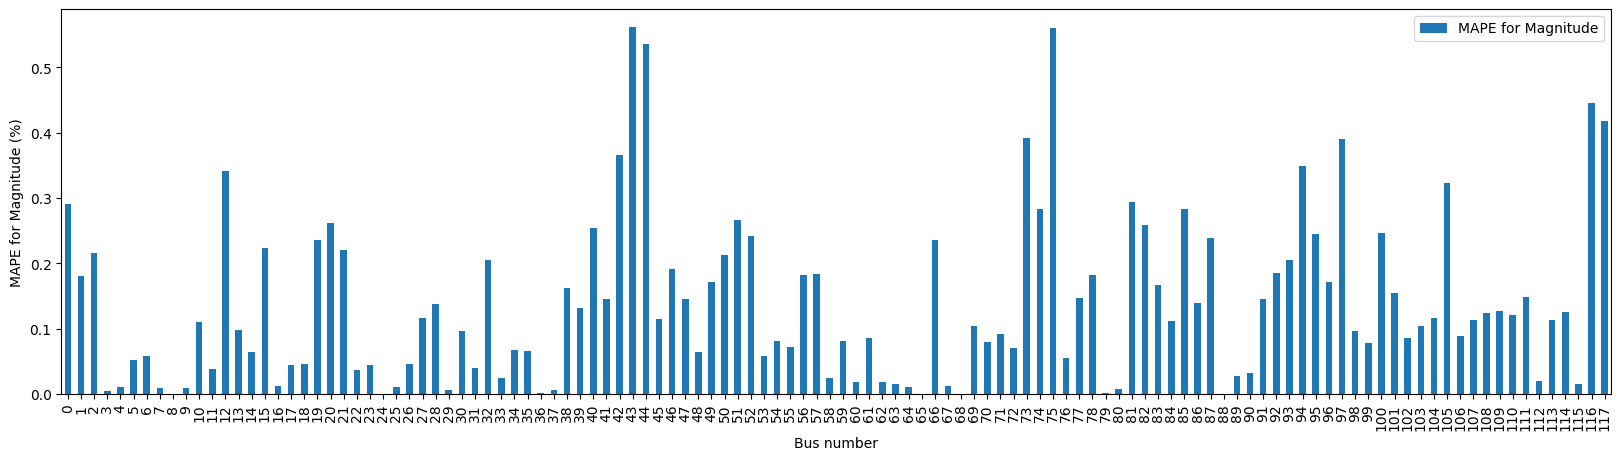

In [29]:
mag_error = mag_MAPE_sep
df = pd.DataFrame({'MAPE for Magnitude':mag_error })

# colors = ['blue'] * len(mag_error)
# colors[67] = 'red'   # Change the color of the first bar
# colors[497] = 'red' # Change the color of the last bar


df.plot(kind='bar',figsize=(20,5), xlabel=('Bus number'), ylabel=('MAPE for Magnitude (%)'))

plt.show()

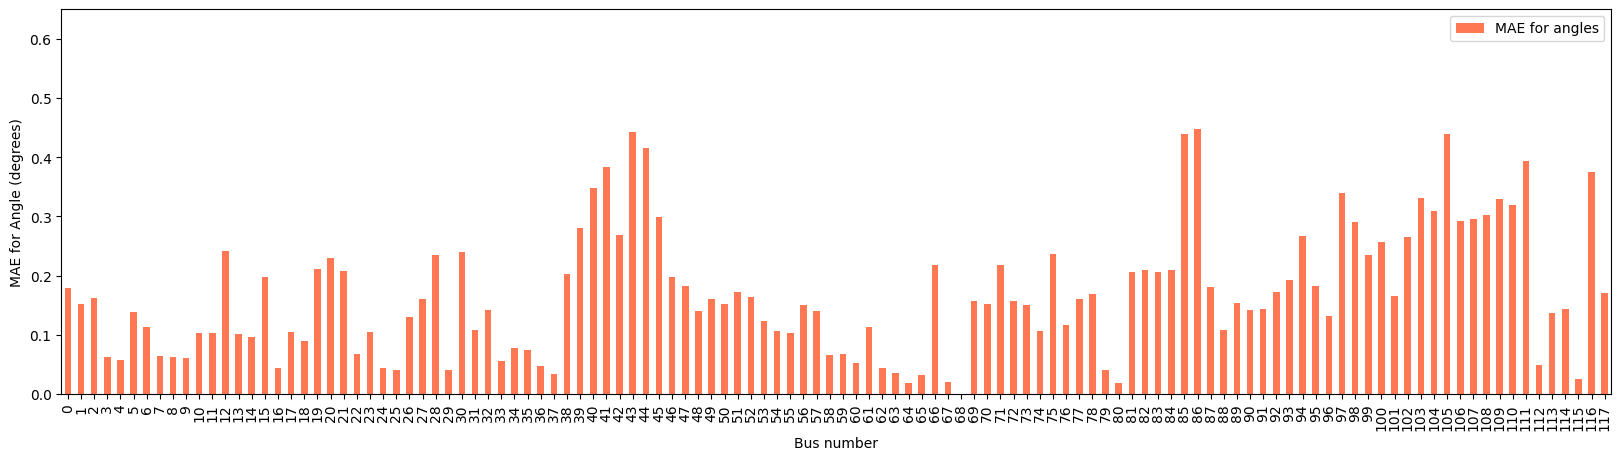

In [30]:
ang_error = ang_MAE_sep
df = pd.DataFrame({'MAE for angles': ang_error })

ax = df.plot(kind='bar',figsize=(20,5), color='#FF7753', xlabel=('Bus number'), ylabel=('MAE for Angle (degrees)'))
ax.set_ylim([0, 0.65])
plt.show()